In [ ]:
!pip install -q Kaggle
!pip install librosa resampy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 13.4 MB/s eta 0:00:00


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alimaparveen","key":"e1fc897b89274e0eef2718f700360259"}'}

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
! kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess

 99% 425M/428M [00:03<00:00, 116MB/s]
100% 428M/428M [00:03<00:00, 126MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/toronto-emotional-speech-set-tess.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

### CNN MODEL TRAINING FOR AUDIO DATA

In [ ]:
import numpy as np
import pandas as pd
import os
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [ ]:
# !pip uninstall -y librosa resampy
# !pip install librosa resampy


In [ ]:
data_path = '/content/TESS Toronto emotional speech set data'

# Initialize empty lists to store audio features and labels
features = []
labels = []

# Recursively search for audio files in all folders within the dataset directory
for root, dirs, files in os.walk(data_path):
    for filename in files:
        if filename.endswith('.wav'):
            try:
                # Load the audio file and extract features using librosa
                audio, sample_rate = librosa.load(os.path.join(root, filename), res_type='kaiser_fast')
                mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
                mfccs_processed = np.mean(mfccs.T,axis=0)

                # Extract emotion label from the file name
                emotion_label = filename.split('_')[-1].split('.')[0]

                # Append features and corresponding label to the lists
                features.append(mfccs_processed)
                labels.append(emotion_label)
            except Exception as e:
                print(f"Error processing file {filename}: {str(e)}")

# Convert lists to numpy arrays
X = np.array(features)
y = np.array(labels)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Convert labels to categorical format
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)


In [ ]:
print("Shape of X_train:", X_train.shape)
# Assuming you have 7 classes in your dataset
num_classes = 7

# Adjust the output layer to have num_classes units
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1], 1, 1), padding='same'),
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Output layer with num_classes units for multi-class classification
])

Shape of X_train: (2240, 40)


In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(X_train[..., np.newaxis], y_train_categorical,
                    validation_data=(X_test[..., np.newaxis], y_test_categorical),
                    epochs=20, batch_size=32)

Epoch 1/20
70/70 [==============================] - 2s 18ms/step - loss: 1.0476 - accuracy: 0.6598 - val_loss: 0.2197 - val_accuracy: 0.9393
Epoch 2/20
70/70 [==============================] - 1s 14ms/step - loss: 0.2700 - accuracy: 0.9134 - val_loss: 0.1055 - val_accuracy: 0.9643
Epoch 3/20
70/70 [==============================] - 1s 14ms/step - loss: 0.1576 - accuracy: 0.9504 - val_loss: 0.0630 - val_accuracy: 0.9804
Epoch 4/20
70/70 [==============================] - 1s 13ms/step - loss: 0.1007 - accuracy: 0.9674 - val_loss: 0.0481 - val_accuracy: 0.9857
Epoch 5/20
70/70 [==============================] - 1s 14ms/step - loss: 0.0834 - accuracy: 0.9750 - val_loss: 0.0514 - val_accuracy: 0.9839
Epoch 6/20
70/70 [==============================] - 1s 13ms/step - loss: 0.0782 - accuracy: 0.9741 - val_loss: 0.0688 - val_accuracy: 0.9786
Epoch 7/20
70/70 [==============================] - 1s 14ms/step - loss: 0.0816 - accuracy: 0.9683 - val_loss: 0.0424 - val_accuracy: 0.9857
Epoch 8/20
70

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test[..., np.newaxis], y_test_categorical)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

18/18 [==============================] - 0s 7ms/step - loss: 0.0421 - accuracy: 0.9875
Test Loss: 0.042121510952711105, Test Accuracy: 0.987500011920929


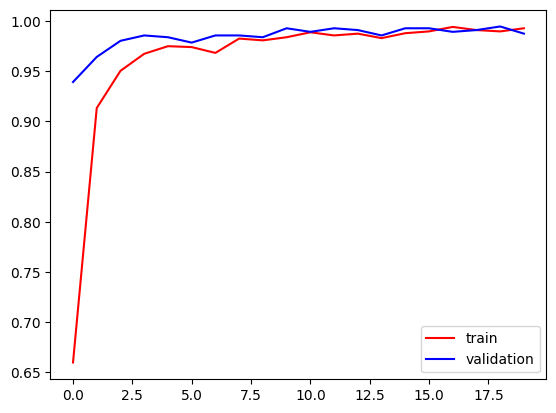

In [ ]:
# accuracy graph
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

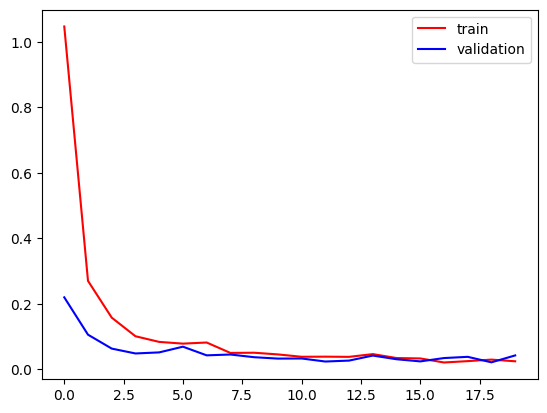

In [ ]:
# loss graph
import matplotlib.pyplot as plt

plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model_path = '/content/drive/MyDrive/Train_model/trained_model.h5'

# Save the model to disk
model.save(model_path)

print("Model saved successfully at:", model_path)

Model saved successfully at: /content/drive/MyDrive/Train_model/trained_model.h5


In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 40, 1, 32)         320       
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 1, 64)         18496     
                                                                 
 flatten (Flatten)           (None, 2560)              0         
                                                                 
 dense (Dense)               (None, 128)               327808    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                                 
Total params: 347527 (1.33 MB)
Trainable params: 347527 

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(X_test[..., np.newaxis],y_test_categorical)[1]*100 , "%")

epochs = [i for i in range(15)]
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

18/18 [==============================] - 0s 5ms/step - loss: 0.0421 - accuracy: 0.9875
Accuracy of our model on test data :  98.7500011920929 %


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Predict classes for the test data
y_pred = np.argmax(model.predict(X_test[..., np.newaxis]), axis=-1)

# Convert predicted class probabilities to class labels
predicted_labels = le.inverse_transform(y_pred)

# Convert actual class probabilities to class labels
actual_labels = le.inverse_transform(y_test)

# Create a DataFrame to display actual and predicted values
results_df = pd.DataFrame({'Actual': actual_labels, 'Predicted': predicted_labels})

df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = predicted_labels.flatten()
df0['Actual Labels'] = actual_labels.flatten()

# # Display the first few rows of the DataFrame
# print("Actual vs Predicted Values:")
# print(results_df.head())

df0.head(10)



18/18 [==============================] - 0s 4ms/step


,Predicted Labels,Actual Labels
0,sad,sad
1,neutral,neutral
2,angry,angry
3,sad,sad
4,sad,sad
5,fear,fear
6,ps,ps
7,happy,happy
8,neutral,neutral
9,sad,sad


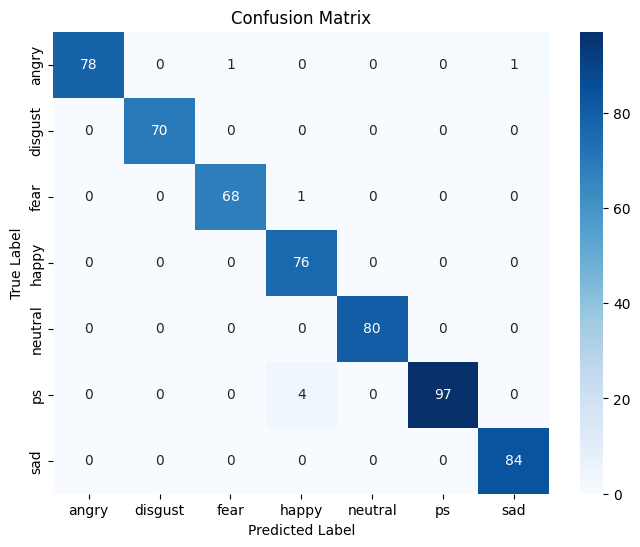


Classification Report:
              precision    recall  f1-score   support

       angry       1.00      0.97      0.99        80
     disgust       1.00      1.00      1.00        70
        fear       0.99      0.99      0.99        69
       happy       0.94      1.00      0.97        76
     neutral       1.00      1.00      1.00        80
          ps       1.00      0.96      0.98       101
         sad       0.99      1.00      0.99        84

    accuracy                           0.99       560
   macro avg       0.99      0.99      0.99       560
weighted avg       0.99      0.99      0.99       560



In [ ]:
# Create confusion matrix
conf_matrix = confusion_matrix(actual_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(actual_labels, predicted_labels))
